In [7]:
import gensim
import re
import os
from tqdm import tqdm
from gensim.models import Doc2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import pandas as pd
from random import sample
import numpy as np
import matplotlib.pyplot as plt
import pymorphy2
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from rake_nltk import Rake

In [8]:
def show_cm(target_test, predicted):
    cm =  metrics.confusion_matrix(target_test, predicted)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)

    cm_display.plot()
    plt.show()

In [9]:
def process_corpus(dir_path: str, eval: str):
    results = []
    morph = pymorphy2.MorphAnalyzer()
    r_model = Rake(language='russian')
    for item in os.listdir(dir_path):
        path = dir_path + '/' + item
        if os.path.isfile(path):
            with open(path, encoding='utf-8') as f:
                text = f.read()
                text = re.split('<\d+>', text)
                for instance in text:
                    words = instance.split(' ')
                    lemmatized_text = [morph.parse(word)[0].normal_form for word in words]
                    lemmatized_text = ' '.join(lemmatized_text)
                    r_model.extract_keywords_from_text(instance)
                    raked_text = ' '.join(r_model.get_ranked_phrases())
                    results.append((instance, lemmatized_text, raked_text, eval))
    return results

In [10]:
def get_data_news(rel_path: str):
    path = os.path.abspath('') + rel_path
    for item in os.listdir(path):
        item_path = path + '/' + item
        if os.path.isdir(item_path):
            results = process_corpus(item_path, item)
            df = pd.DataFrame(results)
            df.to_csv('news_processed.csv', mode='a', index=False, header=False)

In [11]:
get_data_news('/corpus_news')

In [12]:
df = pd.read_csv('news_processed.csv', names=['Raw', 'Lemmatized', 'Rake', 'Evaluation'])

df.head(-10)

,Raw,Lemmatized,Rake,Evaluation
0,Посещение храма Василия Блаженного могут огран...,посещение храм василий блаженный мочь ограничи...,посещение храма василия блаженного могут огран...,culture
1,"Александр Серов назвал Афину идиоткой, дочь св...","александр серов назвать афина идиоткой, дочь с...",время программы произошло сразу несколько непр...,culture
2,"Тарантино сожалеет о ДТП, но душил цепью Уму Т...","тарантино сожалеть о дтп, но душить цепь ум ту...",интервью изданию vulture тарантино признался д...,culture
3,Подарок на 146 лет: 9 и 10 февраля вход в Исто...,подарок на 146 лет: 9 и 10 февраль вход в исто...,экспозиции музея отечественной войны 1812 года...,culture
4,Российским артистам предложили гастролировать ...,российский артист предложить гастролировать на...,железных клетках дмитрий корчинский — известны...,culture
...,...,...,...,...
6309,"Самые древние ""мелки"" окрасили историю первобы...","самый древний ""мелки"" окрасить история первобы...",руки археологов недавно попали самые древние о...,science
6310,На Большом адронном коллайдере обнаружена част...,на большой адронный коллайдер обнаружить части...,большом адронном коллайдере физики заставляли ...,science
6311,Долгожданный скелет рассказывает о туманной ис...,долгожданный скелет рассказывать о туманный ис...,"mansourasaurus shahinae ), впервые раскрывает ...",science
6312,"На орбиту выведена ""звезда человечества"", кото...","на орбита вывести ""звезда человечества"", котор...",объектов ночного неба частная компания rocket ...,science


In [13]:
evals = df['Evaluation']

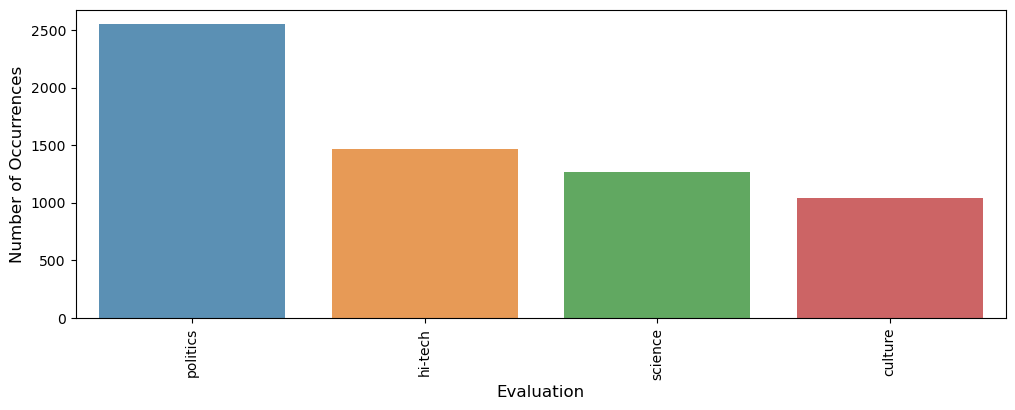

In [19]:
cnt_pro = df['Evaluation'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(x=cnt_pro.index, y=cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Evaluation', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [20]:
train, test = train_test_split(df, test_size=0.3, random_state=42)

In [25]:
import nltk
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [26]:
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Raw']), tags=[r.Evaluation]), axis=1)

test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Raw']), tags=[r.Evaluation]), axis=1)

In [27]:
train_tagged.values[30]

TaggedDocument(words=['путин', 'обсудил', 'макроном', 'меркель', 'происходящее', 'восточной', 'гуте', 'президент', 'рф', 'владимир', 'путин', 'обсудил', 'по', 'телефону', 'главой', 'франции', 'эммануэлем', 'макроном', 'исполняющей', 'обязанности', 'канцлера', 'германии', 'ангелой', 'меркель', 'сирийскую', 'проблему', 'поскольку', 'ситуация', 'восточной', 'гуте', 'развивается', 'требуется', 'доставка', 'гуманитарной', 'помощи', 'этот', 'другие', 'регионы', 'страны', 'особо', 'указывалось', 'что', 'благодаря', 'совместным', 'усилиям', 'удалось', 'принять', 'резолюцию', 'совета', 'безопасности', 'оон', '2401', 'путин', 'сообщил', 'действиях', 'российской', 'стороны', 'гуманитарной', 'помощи', 'эвакуации', 'людей', 'медицинской', 'помощи', 'населению', 'разговоре', 'подчеркивалось', 'что', 'резолюция', 'не', 'распространяется', 'на', 'операции', 'направленные', 'на', 'уничтожение', 'террористических', 'группировок', 'стороны', 'договорились', 'информировать', 'друг', 'друга', 'по', 'ситуац

Doc2Vec

In [28]:
import multiprocessing

cores = multiprocessing.cpu_count()

In [29]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████████████████████████████████████████████████████████████████████| 4426/4426 [00:00<00:00, 764390.57it/s]


In [30]:
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|█████████████████████████████████████████████████████████████████████████| 4426/4426 [00:00<00:00, 1366908.88it/s]


In [33]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words)) for doc in sents])
    return targets, regressors

In [34]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

Classification

In [35]:
clf = RandomForestClassifier(random_state=23)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

#y_pred = np.argmax(clf.predict(X_test), axis=1)

In [37]:
from sklearn import metrics

In [39]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     culture       0.49      0.30      0.37       342
     hi-tech       0.55      0.51      0.53       455
    politics       0.63      0.70      0.66       759
     science       0.57      0.69      0.62       342

    accuracy                           0.58      1898
   macro avg       0.56      0.55      0.55      1898
weighted avg       0.57      0.58      0.57      1898



Visualization

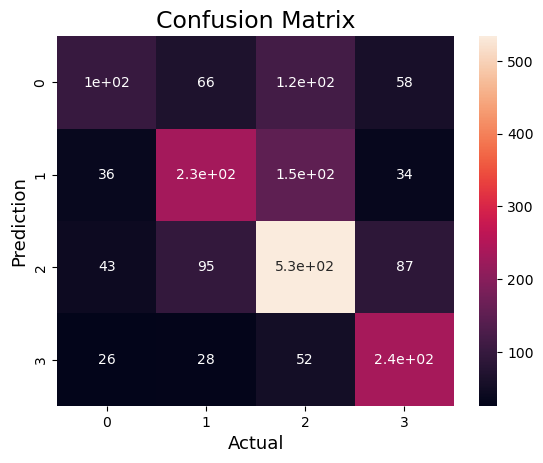

In [41]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm,
            annot=True)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

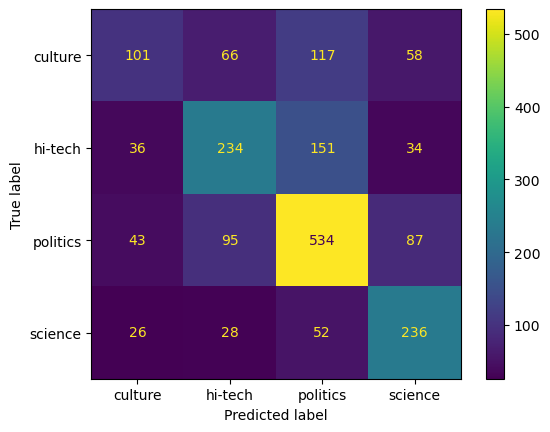

In [47]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
color = 'white'
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()